In [1]:
pip install requests numpy pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install fake-useragent

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import time
import re
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm.notebook import tqdm
import random

In [6]:
UserAgent().chrome

'Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36'

In [7]:
#Собирает ссылки на статьи с главной страницы Habr
def get_article_links(pages=10): #pages - количество страниц для парсинга
    base_url = "https://habr.com/ru/all/page{}/" #шаблон URL для разных страниц {} - номер страницы
    article_links = []
    
    for page in tqdm(range(1, pages + 1), desc="Сбор ссылок"): #tqdm для визуализации
        url = base_url.format(page)
        response = requests.get(url, headers={'User-Agent': UserAgent().chrome}) #useragent имитираует браузер
        
        if response.status_code != 200: #проверка успешности запроса(код 200)
            print(f"Ошибка на странице {page}: {response.status_code}")
            continue
                
        soup = BeautifulSoup(response.content, 'html.parser')
            
        # Поиск ссылок
        articles = soup.find_all('article', class_='tm-articles-list__item')
            
        for article in articles:
            link_tag = article.find('a', class_='tm-title__link')
            if link_tag and 'href' in link_tag.attrs:
                full_link = "https://habr.com" + link_tag['href']
                article_links.append(full_link)
            
        # От блокировки
        time.sleep(random.uniform(1, 3))
    
    # Удалить дубликаты
    article_links = list(set(article_links))
    print(f"Собрано {len(article_links)} уникальных ссылок на статьи")
    return article_links

In [8]:
# # Собирает данные из отдельной статьи
# def parse_article(article_url):
#     # Загрузка и проверка страницы
#     response = requests.get(article_url, headers={'User-Agent': UserAgent().chrome})
#     if response.status_code != 200:
#         return None
        
#     soup = BeautifulSoup(response.content, 'html.parser') # Парсинг html
    
#     data = {}
    
#     title_elem = soup.find('h1', class_='tm-title tm-title_h1')
#     data['title'] = title_elem.text.strip() if title_elem else ""
    
#     author_elem = soup.find('a', class_='tm-user-info__username')
#     data['author'] = author_elem.text.strip() if author_elem else ""
    
#     date_elem = soup.find('time')
#     data['publish_date'] = date_elem['datetime'] if date_elem and 'datetime' in date_elem.attrs else ""
    
#     hubs = []
#     hubs_elems = soup.find_all('a', class_='tm-publication-hub__link')
#     for hub in hubs_elems:
#         hubs.append(hub.text.strip())
#     data['hubs'] = hubs
    
#     article_elem = soup.find('div', class_='tm-article-body')
#     data['text'] = article_elem.text.strip() if article_elem else ""
    
#     views_elem = soup.find('span', class_='tm-icon-counter__value')
#     data['views'] = int(views_elem.text.strip()) if views_elem else 0
    
#     # Преобразование сокращенных чисел 
#     def parse_number(text):
#         if not text:
#             return 0
#         text = text.strip().upper()
#         try:
#             if 'K' in text:
#                 return int(float(text.replace('K', '').replace(',', '.')) * 1000)
#             elif 'M' in text:
#                 return int(float(text.replace('M', '').replace(',', '.')) * 1000000)
#             else:
#                 return int(text)
#         except ValueError:
#             return 0

#     comments_elem = soup.find('span', class_='tm-article-comments-counter-link__value')
#     if comments_elem:
#         comments_text = comments_elem.text.strip()
#         data['comments'] = int(comments_text) if comments_text.isdigit() else 0
#     else:
#         data['comments'] = 0
    
#     rating_elem = soup.find('span', class_='tm-votes-meter__value')
#     data['rating'] = int(rating_elem.text.strip()) if rating_elem else 0
    
#     reading_time_elem = soup.find('span', class_='tm-article-reading-time__label')
#     data['reading_time'] = reading_time_elem.text.strip() if reading_time_elem else ""
    
#     data['url'] = article_url
    
#     # Дополнительные метрики из текста
#     if data['text']:
#         data['text_length'] = len(data['text'])
#         data['word_count'] = len(data['text'].split())
#     else:
#         data['text_length'] = 0
#         data['word_count'] = 0
        
#     return data

In [19]:
def parse_article_2(article_url): 
    response = requests.get(article_url, headers={'User-Agent': UserAgent().chrome})
    soup = BeautifulSoup(response.content, 'html.parser')
    
    data = {}
    
    # Преобразование сокращенных чисел (1,7k = 1700)
    def parse_number(text):
        if not text:
            return 0
        text = str(text).strip().upper()
        if 'K' in text:
            return int(float(text.replace('K', '').replace(',', '.')) * 1000)
        elif 'M' in text:
            return int(float(text.replace('M', '').replace(',', '.')) * 1000000)
        else:
            # Удалить все нецифровые символы, кроме точки и запятой
            cleaned = re.sub(r'[^\d.,]', '', text)
            cleaned = cleaned.replace(',', '.')
            return int(float(cleaned)) if cleaned else 0
    
    title_elem = soup.find('h1')
    data['title'] = title_elem.text.strip() if title_elem else "No title"

    author_elem = (soup.find('a', class_='tm-user-info__username') or 
                    soup.find('span', class_='tm-user-info__username') or
                    soup.find('a', class_='tm-user-info__name'))
    data['author'] = author_elem.text.strip() if author_elem else "Unknown"
    
    date_elem = soup.find('time')
    data['publish_date'] = date_elem.get('datetime', '') if date_elem else ""
    
    hubs = []
    hubs_containers = [
        soup.find_all('a', class_='tm-publication-hub__link'),
        soup.find_all('a', class_='tm-hubs-list__hub-link'),
        soup.find_all('span', class_='tm-publication-hub__link')
    ]
    
    for container in hubs_containers:
        if container:
            for hub in container:
                hub_text = hub.text.strip()
                if hub_text and hub_text not in hubs:
                    hubs.append(hub_text)
            break  # Использовать первый найденный контейнер
    
    data['hubs'] = hubs
    
    article_body = (soup.find('div', class_='tm-article-body') or 
                    soup.find('article') or
                    soup.find('div', class_='post__text'))
    data['text'] = article_body.text.strip() if article_body else ""
    
    counters = soup.find_all('span', class_=lambda x: x and 'counter' in x)
    
    views_elem = soup.find('span', class_='tm-icon-counter__value')
    if not views_elem:
        # Альтернативный поиск
        views_text = re.search(r'(\d+[\d.,KkMм]*)\s*(просмотр|view)', str(soup))
        if views_text:
            data['views'] = parse_number(views_text.group(1))
        else:
            data['views'] = 0
    else:
        data['views'] = parse_number(views_elem.text)
    
    comments_elem = soup.find('span', class_='tm-article-comments-counter-link__value')
    if not comments_elem:
        comments_elem = soup.find('a', href=re.compile('#comments'))
        if comments_elem:
            comments_text = re.search(r'(\d+[\d.,KkMм]*)', comments_elem.text)
            data['comments'] = parse_number(comments_text.group(1)) if comments_text else 0
        else:
            data['comments'] = 0
    else:
        data['comments'] = parse_number(comments_elem.text)
    
    rating_elem = soup.find('span', class_='tm-votes-meter__value')
    data['rating'] = parse_number(rating_elem.text) if rating_elem else 0
    
    reading_time_elem = (soup.find('span', class_='tm-article-reading-time__label') or
                        soup.find('span', string=re.compile('мин|min')))
    data['reading_time'] = reading_time_elem.text.strip() if reading_time_elem else ""
    
    data['url'] = article_url
    
    # Дополнительные метрики
    data['text_length'] = len(data['text'])
    data['word_count'] = len(data['text'].split())
    data['hubs_count'] = len(data['hubs'])
        
    return data
    

In [10]:
pip show ipywidgets

Name: ipywidgets
Version: 8.1.8
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: c:\Users\anmrt\Desktop\Useful shit\nlp_labs\venv\Lib\site-packages
Requires: comm, ipython, jupyterlab_widgets, traitlets, widgetsnbextension
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
pip install --upgrade ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [20]:
def main():
    article_links = get_article_links(pages=5) 
    
    # Сохранение ссылок в файл
    with open('habr_article_links.txt', 'w', encoding='utf-8') as f:
        for link in article_links:
            f.write(link + '\n')
    
    # Парсинг статей
    articles_data = []
    
    for i, link in enumerate(tqdm(article_links, desc="Парсинг статей")):
        article_data = parse_article_2(link)  # Используем надежную версию
        if article_data:
            articles_data.append(article_data)
            print(f"Спарсена статья: {article_data['title'][:50]}... (просмотров: {article_data['views']})")
        else:
            print(f"Не удалось спарсить: {link}")
        
        time.sleep(random.uniform(3, 6))
        
        # Сохранение прогресса каждые 10 статей
        if i % 10 == 0 and i > 0 and articles_data:
            temp_df = pd.DataFrame(articles_data)
            temp_df.to_csv(f'habr_articles_progress_{i}.csv', index=False, encoding='utf-8')
            print(f"Сохранен прогресс после {i} статей")
    
    # Сохранение финального датасета
    if articles_data:
        print("\nЭтап 3: Сохранение данных")
        df = pd.DataFrame(articles_data)
        
        # В CSV
        df.to_csv('habr_articles_dataset.csv', index=False, encoding='utf-8')
        
        print(f"\nСбор данных завершен!")
        print(f"Всего собрано статей: {len(df)}")
        print(f"Столбцы в датасете: {list(df.columns)}")
        
        print("\nБазовая статистика:")
        print(f"Среднее количество просмотров: {df['views'].mean():.0f}")
        print(f"Медианное количество просмотров: {df['views'].median():.0f}")
        print(f"Среднее количество комментариев: {df['comments'].mean():.0f}")
        print(f"Средняя длина текста: {df['text_length'].mean():.0f} символов")
        
        return df

if __name__ == "__main__":
    df = main()

Сбор ссылок:   0%|          | 0/5 [00:00<?, ?it/s]

Собрано 100 уникальных ссылок на статьи


Парсинг статей:   0%|          | 0/100 [00:00<?, ?it/s]

Спарсена статья: Передача информации почти без затрат энергии... (просмотров: 790)
Спарсена статья: Как сделать видео с нейросетями: простой гайд от и... (просмотров: 728)
Спарсена статья: Как я начал создавать медицинские изделия, ч.3... (просмотров: 807)
Спарсена статья: MQTT + MODBUS + WEB: как DRM88ER решает задачи сов... (просмотров: 609)
Спарсена статья: Как работает компьютер. Простая статья для начинаю... (просмотров: 8000)
Спарсена статья: Не только трансформеры: за пределами стандартных а... (просмотров: 1600)
Спарсена статья: Матрица трассировки: от хаоса к системности, или к... (просмотров: 15)
Спарсена статья: Кодирование с помощью параметризации нечётных чисе... (просмотров: 581)
Спарсена статья: Отдел Технического Контроля на заводе по производс... (просмотров: 337)
Спарсена статья: Почему LLM не заменит хорошего разработчика, но сд... (просмотров: 290)
Спарсена статья: Мы делали продукт, они — презентацию. Угадайте, кт... (просмотров: 1900)
Сохранен прогресс после 10 ст

In [21]:
pip install matplotlib seaborn wordcloud nltk

  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.5 kB ? eta -:--:--
     ------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [23]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anmrt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anmrt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
df = pd.read_csv('habr_articles_dataset.csv')
print(df.shape)

print(df.head())


print(df.info())


print(df.describe())

(100, 13)
                                               title        author  \
0       Передача информации почти без затрат энергии       ALT0105   
1  Как сделать видео с нейросетями: простой гайд ...  zaharovpavel   
2     Как я начал создавать медицинские изделия, ч.3       RealZel   
3  MQTT + MODBUS + WEB: как DRM88ER решает задачи...      Razumdom   
4  Как работает компьютер. Простая статья для нач...       taydvax   

               publish_date  \
0  2025-11-09T14:33:23.000Z   
1  2025-11-09T14:09:33.000Z   
2  2025-11-09T13:30:31.000Z   
3  2025-11-10T06:12:03.000Z   
4  2025-11-09T15:58:05.000Z   

                                                hubs  \
0  ['Системы связи *', 'Сотовая связь', 'Стандарт...   
1  ['Интернет-маркетинг *', 'Искусственный интелл...   
2  ['Прототипирование *', 'Схемотехника *', 'Здор...   
3  ['Умный дом', 'DIY или Сделай сам', 'Визуализа...   
4  ['Инженерные системы *', 'Компьютерное железо'...   

                                             

In [27]:
# Пропущенные значения
print(df.isnull().sum())

title           0
author          0
publish_date    0
hubs            0
text            0
views           0
comments        0
rating          0
reading_time    0
url             0
text_length     0
word_count      0
hubs_count      0
dtype: int64


In [28]:
# Заполнение пропусков
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('No title')
df['author'] = df['author'].fillna('Unknown')

# Удаление дубликатов
initial_size = len(df)
df = df.drop_duplicates(subset=['url', 'title'])

# Преобразование даты
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

# Добавление новых признаков
df['publish_year'] = df['publish_date'].dt.year
df['publish_month'] = df['publish_date'].dt.month
df['avg_reading_speed'] = df['text_length'] / (df['word_count'] + 1)  # средняя длина слова

In [29]:
print(len(df))

100


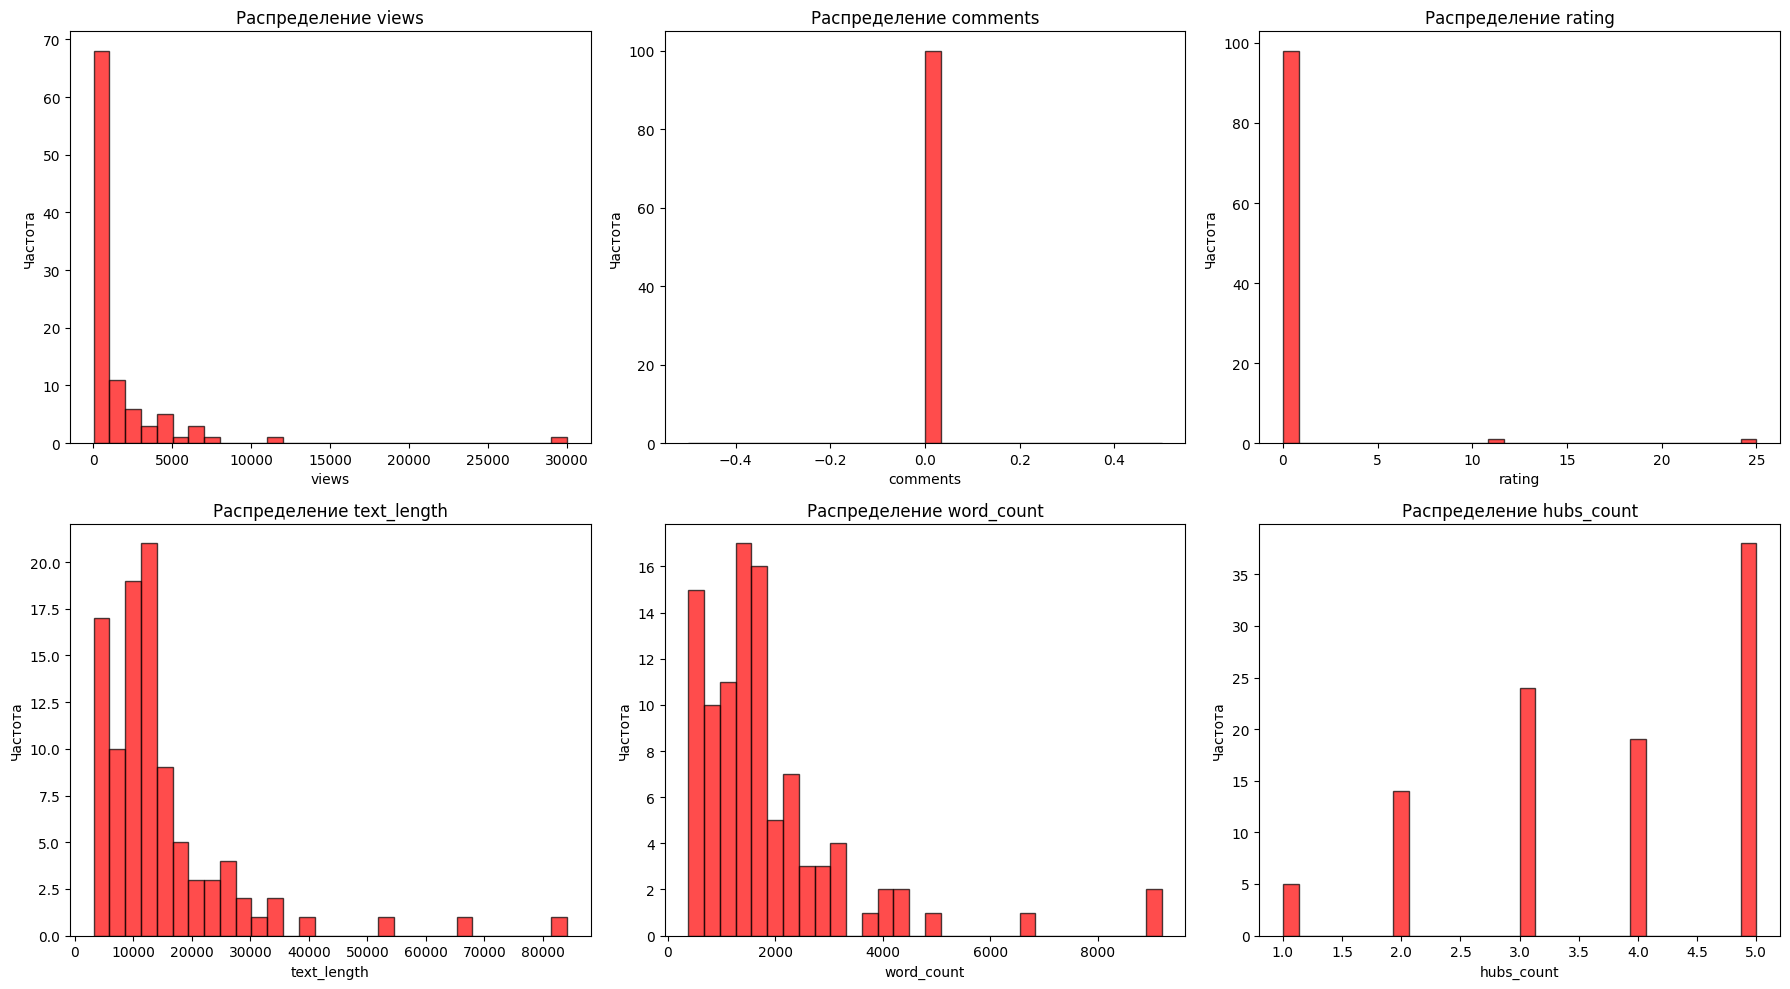

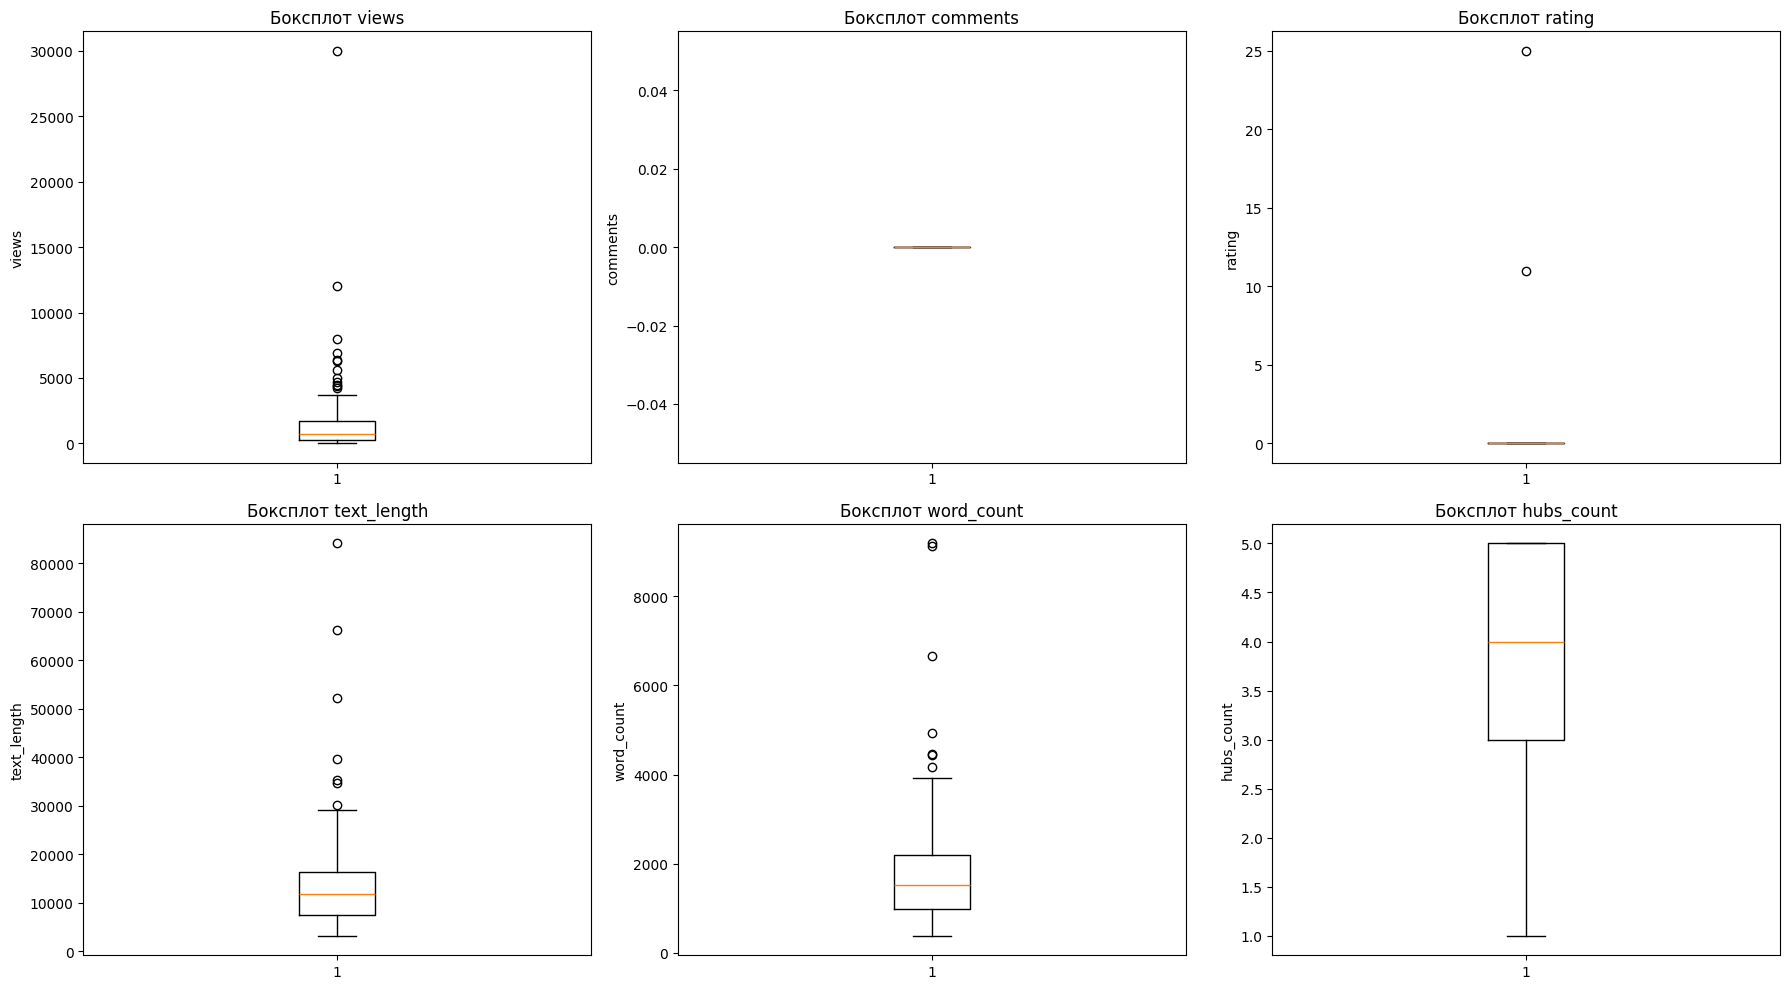

In [31]:
numeric_cols = ['views', 'comments', 'rating', 'text_length', 'word_count', 'hubs_count']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Боксплоты для выбросов
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Боксплот {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()